<a href="https://colab.research.google.com/github/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [12]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches

# (It may complain that some files are missing because the files seem to have been
# reorganized on the underlying website, but it still seems to work). If everything is working
# properly, then the whole notebook should run to the end without further problems
# even before you make changes.
batch_size_train = 64
batch_size_test = 1000

# TODO Change this directory to point towards an existing directory
myDir = '/files/'

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

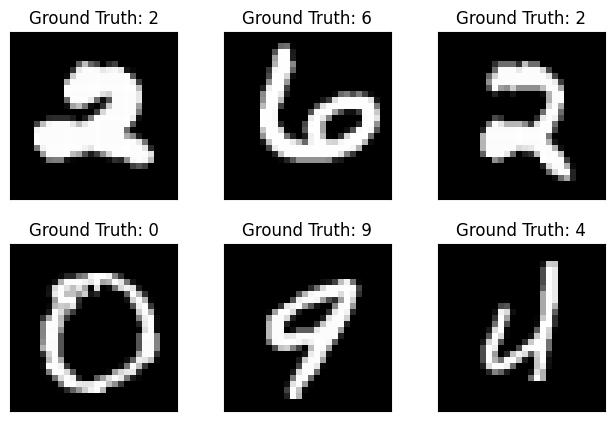

In [13]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [14]:
from os import X_OK
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self, img_width,img_height):
        super(Net, self).__init__()
        # Valid convolution, 1 channel in, 2 channels out, stride 1, kernel size = 3
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(10, 20, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          # rafael: vi como es el calculo. Igual imprimi el valor antes del flatten para obtenerlo
          nn.Linear(320,50),
          nn.ReLU(),
          nn.Linear(50,10),
          # rafael: aqui estaba Softmax en el template, el loss daba resultados negativos a causa de eso
          # lo cambie por logSoftmax y volvemos a tener loss positivo
          # la precision ademas aumento gracias a este cambio
          # https://datascience.stackexchange.com/questions/40714/what-is-the-advantage-of-using-log-softmax-instead-of-softmax
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)



In [15]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [16]:
# Create network
model = Net(28,28)
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [17]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [18]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.4676, Accuracy: 1003/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: 2.502613
Train Epoch: 1 [640/60000]	Loss: 1.993189
Train Epoch: 1 [1280/60000]	Loss: 1.542025
Train Epoch: 1 [1920/60000]	Loss: 1.004529
Train Epoch: 1 [2560/60000]	Loss: 0.709561
Train Epoch: 1 [3200/60000]	Loss: 0.740172
Train Epoch: 1 [3840/60000]	Loss: 0.745612
Train Epoch: 1 [4480/60000]	Loss: 0.722698
Train Epoch: 1 [5120/60000]	Loss: 0.508119
Train Epoch: 1 [5760/60000]	Loss: 0.416820
Train Epoch: 1 [6400/60000]	Loss: 0.490381
Train Epoch: 1 [7040/60000]	Loss: 0.310512
Train Epoch: 1 [7680/60000]	Loss: 0.433311
Train Epoch: 1 [8320/60000]	Loss: 0.627928
Train Epoch: 1 [8960/60000]	Loss: 0.331507
Train Epoch: 1 [9600/60000]	Loss: 0.301747
Train Epoch: 1 [10240/60000]	Loss: 0.262561
Train Epoch: 1 [10880/60000]	Loss: 0.485194
Train Epoch: 1 [11520/60000]	Loss: 0.624979
Train Epoch: 1 [12160/60000]	Loss: 0.285844
Train Epoch: 1 [12800/60000]	Loss: 0.183011
Train Epoch: 1 [13440/60000]	Loss: 0.2

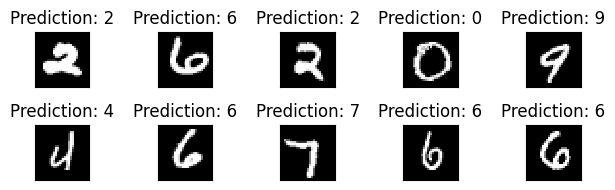

In [20]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()